<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Загрузим необходимые для выполнения исследования библиотеки и константы:

In [1]:
!pip install wordcloud
!pip install transformers

     |████████████████████████████████| 513 kB 2.5 MB/s eta 0:00:01


In [46]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
import transformers
import nltk
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from tqdm import notebook
tqdm.pandas()
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [3]:
TEST_SIZE = 0.25
RANDOM_STATE = 12345

Загрузим исследуемый датасет с текстами:

In [4]:
try:
  from google.colab import drive
  drive.mount('/content/drive')

except:
  pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
try:
    csv_file_path = '/content/drive/My Drive/Toxic_comments/toxic_comments.csv'
    df = pd.read_csv(csv_file_path, index_col=[0])

except:
    df = pd.read_csv('/datasets/toxic_comments.csv',  index_col=[0])

Выведем первые пять строк датасета для проверки корректности загрузки:

In [6]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Датасет загружен корректно

Изучим распредление целевого признака 'toxic':

In [7]:
df['toxic'].value_counts()

,count
toxic,
0,143106
1,16186


Для вывода распределения в виде графика воспользуемся функцией count_graph:

In [8]:
def count_graph(df, col, name):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax = sns.countplot(y=df[col])
    ax.set_title(name);

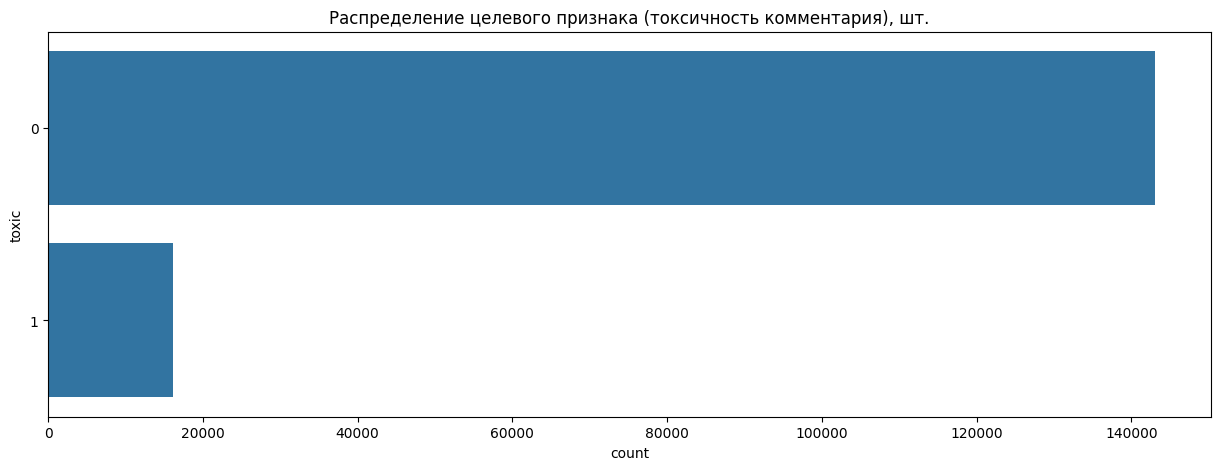

In [9]:
count_graph(df, 'toxic', 'Распределение целевого признака (токсичность комментария), шт.')

Посмотрим на распределение количества слов в тексте комментариев, для этого создадим новый столбец 'word_count':

In [10]:
df['word_count'] = df['text'].str.split().str.len()

In [11]:
df.head()

,text,toxic,word_count
0,Explanation\nWhy the edits made under my usern...,0,43
1,D'aww! He matches this background colour I'm s...,0,17
2,"Hey man, I'm really not trying to edit war. It...",0,42
3,"""\nMore\nI can't make any real suggestions on ...",0,113
4,"You, sir, are my hero. Any chance you remember...",0,13


Посмотрим на статистики распределения нового признака, в том числе в разбивке по таргету:

In [12]:
df['word_count'].describe().T

,word_count
count,159292.000000
mean,67.213545
std,99.133908
min,1.000000
25%,17.000000
50%,36.000000
75%,75.000000
max,1411.000000


In [13]:
df[df['toxic']==1]['word_count'].describe().T

,word_count
count,16186.000000
mean,52.677314
std,106.772843
min,1.000000
25%,11.000000
50%,23.000000
75%,50.000000
max,1411.000000


In [14]:
df[df['toxic']==0]['word_count'].describe().T

,word_count
count,143106.000000
mean,68.857665
std,98.097420
min,1.000000
25%,18.000000
50%,37.000000
75%,78.000000
max,1250.000000


Как видно из таблиц выше, среднее количество слов в нетоксичных комментариях превышает аналогичное в токсичных комментриях более чем на 30% (68.857665 и 2.677314 соответственно), а медианное значение более чем 60% (37 и 23 соответственно). В связи со значительной разнице в рапсределении количества слов по таргету, прдланается использовать данный признак в процессе обучения.

Визуализируем полученные выше средние и медианные значения количества слов в комментариях, с разбивкой по таргету

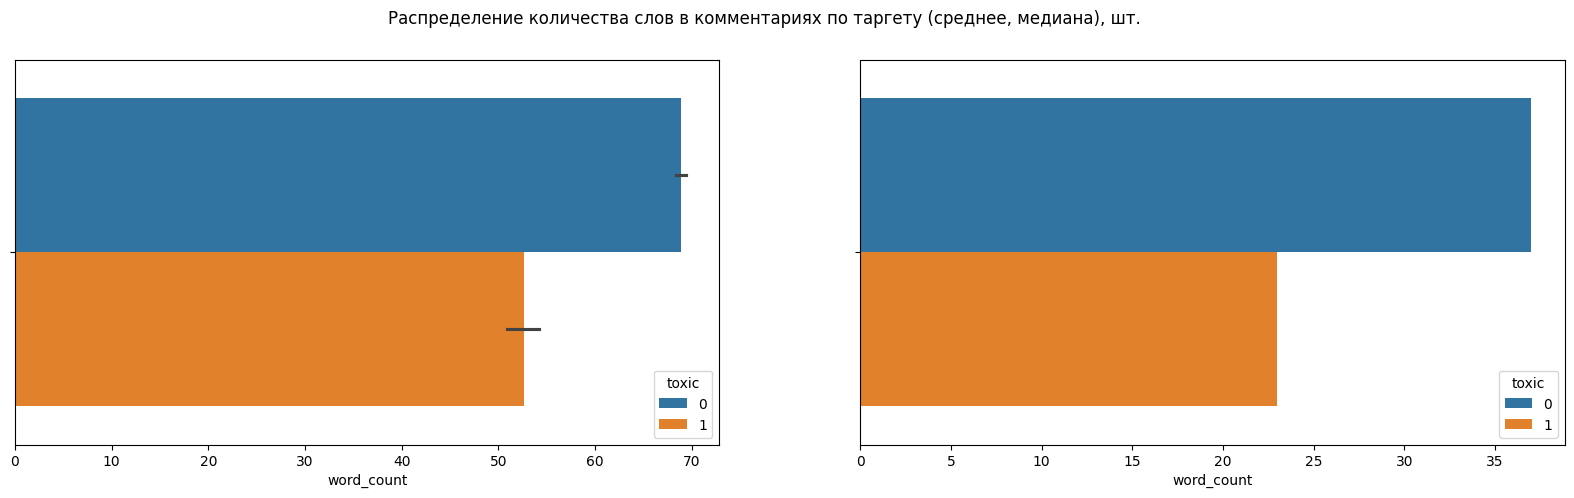

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.barplot(data=df, x='word_count', ax=axes[0], hue='toxic')
sns.barplot(data=df, x='word_count', ax=axes[1], hue='toxic', estimator=np.median, ci=None)
fig.suptitle('Распределение количества слов в комментариях по таргету (среднее, медиана), шт.');

Сформируем "облако слов" для комментариев в разбивке по таргету.
Создадим список слов имеющих таргет 0:

In [16]:
raw_0 = ' '.join(df[df['toxic']==0]['text'])

Получим облако слов:

In [17]:
wordcloud_0 = WordCloud(collocations=False).generate(raw_0)

Визуализируем полученное облако:

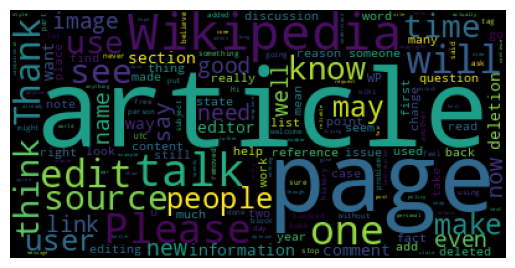

In [18]:
plt.imshow(wordcloud_0)
plt.axis("off");

Аналогично для таргета 'toxic' = 1:

In [19]:
raw_1 = ' '.join(df[df['toxic']==1]['text'])

In [20]:
wordcloud_1 = WordCloud(collocations=False).generate(raw_1)

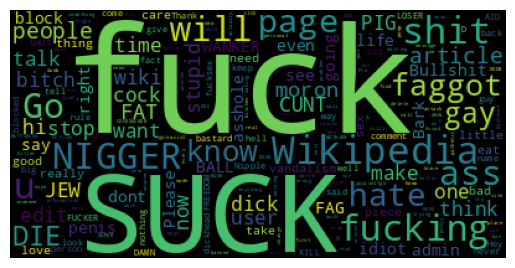

In [21]:
plt.imshow(wordcloud_1)
plt.axis("off");

Как видно на графике выше, для негативных комменатриев характерны слова 'fuck', 'suck', NIGGER и т.д., для комментариев не имеющих негативного окраса - 'article', 'page', 'Wikipedia', 'Please'.

Далее выполним предобработку датасета и дальнейшее обучение моделей без использования модели BERT, а также с ее помощью

**Предобработка текста без использования BERT**

Создадим класс и функцию для лемматизации исследуемых текстов:

Лемматизированные тексты сохраним в столбце 'lemm_text'. Столбец 'text' с исходными текстами удалим

In [22]:
lemmatizer = WordNetLemmatizer()

In [23]:
def lemmatize_sentence(sentence):
    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    lemmatized_words = [lemmatizer.lemmatize(w.lower(), get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)]

    cleaned_text = re.sub(r'[^a-zA-Z]', ' ', ' '.join(lemmatized_words))

    return " ".join(cleaned_text.split())

In [24]:
df['lemmatized_text'] = df['text'].progress_apply(lemmatize_sentence)
df = df.drop(['text'], axis=1)

  0%|          | 0/159292 [00:00<?, ?it/s]

Выведем результат в виде первых пяти строк:

In [25]:
df.head()

,toxic,word_count,lemmatized_text
0,0,43,explanation why the edits make under my userna...
1,0,17,d aww he match this background colour i m seem...
2,0,42,hey man i m really not try to edit war it s ju...
3,0,113,more i ca n t make any real suggestion on impr...
4,0,13,you sir be my hero any chance you remember wha...


Как видно из таблицы выше, текст лемматизирован.

Повтороно выведем "облако слов" с разбивкой по таргету, для лемматизированного и очищенного датасета.
Для 'toxic' = 0:

In [26]:
raw_0_lem = ' '.join(df[df['toxic']==0]['lemmatized_text'])

In [27]:
wordcloud_0_lem = WordCloud(collocations=False).generate(raw_0_lem)

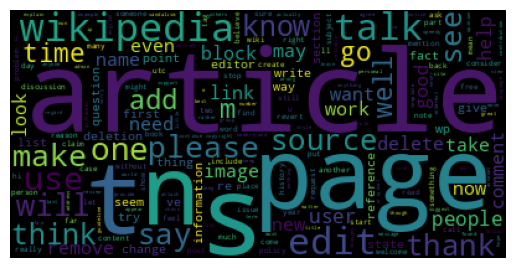

In [28]:
plt.imshow(wordcloud_0_lem)
plt.axis("off");

Для 'toxic' = 1:

In [29]:
raw_1_lem = ' '.join(df[df['toxic']==1]['lemmatized_text'])

In [30]:
wordcloud_1_lem = WordCloud(collocations=False).generate(raw_1_lem)

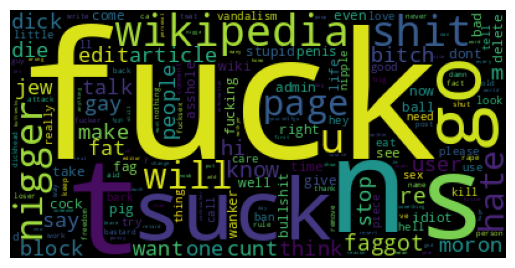

In [31]:
plt.imshow(wordcloud_1_lem)
plt.axis("off");

Как видно на графике выше, после лемматизации и очистки "облако слов" претерпело изменения:  для негативных комменатриев характерны слова 'fuck', 'suck', 'go' и т.д., для комментариев не имеющих негативного окраса - 'article', 'page', 'please', 'Wikipedia'.

Создадим переменные X и y для дальнейшего разделения на обучающую и тестовую выборки

In [32]:
X = df.drop('toxic', axis=1)

In [33]:
y = df['toxic']

Разделим датасет на обучающую и тестовую выборки:


In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

**Предобработка текста c помощью BERT**

Инициализируем токенизатор как объект класса AutoTokenizer() с предобученной моделью toxic-bert:

In [35]:
model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Применим метод padding чтобы после токенизации длины исходных текстов в корпусе были равными. Также «создадим маску» для действительно важных токенов, то есть укажем нулевые и не нулевые значения:

In [36]:
tokenized = df['lemmatized_text'].apply(
    lambda x: tokenizer.encode(x, max_length=512, truncation=True, add_special_tokens=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

Определим размер батча:

In [37]:
batch_size = 100

Преобразуем данные исходные данные в тензоры, для дальнейшего получения эмбеддингов, с помощью модели BERT:

In [40]:
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).cuda()
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).cuda()

    with torch.no_grad():
        model.cuda()
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/1592 [00:00<?, ?it/s]

Объединим эмбеддинги в матрицу признаков вызовом функции concatenate():

In [41]:
features = np.concatenate(embeddings)

Разделим полученные данные на обучающую и тестовую выборку:

In [42]:
X_bert = features

In [43]:
y_bert = df['toxic'].iloc[0:159200]

In [44]:
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    X_bert,
    y_bert,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

**Вывод:** В рамках данного раздела:
- загружены и проверены на корректность загрузки и отображения исследуемые данные;
- исследовано распределение значений целевого признака 'toxic' - распределение несбалансировано, количество нетоксичных комментариев существенно превышает количество токсичных;
- исследовано среднее и медианное количество слов для токсичных и нетоксичных комментариев: среднее количество слов в нетоксичных комментариях превышает аналогичное в токсичных комментриях, более чем на 30% (68.857665 и 2.677314 соответственно), а медианное значение более чем 60% (37 и 23 соответственно). В связи со значительной разнице в рапсределении количества слов по таргету, прдланается использовать данный признак в процессе обучения.
- выведено "облако слов" с разбивкой по таргету до лемматизации и очистки текста и после. До лемматизации и очистки текста для негативных комменатриев характерны слова 'fuck', 'suck', NIGGER и т.д., для комментариев не имеющих негативного окраса - 'article', 'page', 'Wikipedia', 'Please'. После лемматизации и очистки для негативных комменатриев характерны слова 'fuck', 'suck', 'go' и т.д., для комментариев не имеющих негативного окраса - 'article', 'page', 'please', 'Wikipedia'.
- исследуемые тексты подготовлены к обучению:
а) без помощи модели BERT: тексты лематизированы, очищены и разеделены на обучающую и тестовую выборки
б) с помощью модели BERT подготоволена ораниченная случайная выборка в 20000 экземпляров (ввиду ресурсоемкого преобразования), выборка разеделена на обучающую и тестовую

## Обучение

**Обучение и получение прогнозов без использования BERT**

Обучим и получим предсказания на предобработанном выше тексте, с помощью пайплайна и моделей PassiveAggressiveClassifier, LogisticRegression, также переберем различное количество N-грамм для TfidfVectorizer(stop_words='english')). Перебор параметров выполним с помощью метода GridSearchCV


In [64]:
data_preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(stop_words='english'), 'lemmatized_text'),
        ('num', StandardScaler(), ['word_count'])
    ],
    remainder='passthrough'
)

text_pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', None)
])

param_grid = [
    {
        'models': [PassiveAggressiveClassifier(random_state=RANDOM_STATE, max_iter=50)],
        'preprocessor__tfidf__ngram_range': [(1, 2), (2, 3), (3, 4)]
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': [0.1, 1, 10],
        'preprocessor__tfidf__ngram_range': [(1, 2), (2, 3), (3, 4)]
    }
]

grid_search = GridSearchCV(
    text_pipe,
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print('Лучшая модель на кросс-валидации:', grid_search.best_estimator_)
print('Лучшие параметры на кросс-валидации:', grid_search.best_params_)
print('Метрика лучшей модели на кроссвалидации:', grid_search.best_score_)

Best model on cross-validation: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'lemmatized_text'),
                                                 ('num', StandardScaler(),
                                                  ['word_count'])])),
                ('models',
                 PassiveAggressiveClassifier(max_iter=50, random_state=12345))])
Best parameters on cross-validation: {'models': PassiveAggressiveClassifier(max_iter=50, random_state=12345), 'preprocessor__tfidf__ngram_range': (1, 2)}
Best score for the best model on cross-validation: 0.7749626222058884


Как видно по итогам работы пайплайна лучшую метрику f1 = 0.7750 на кросс-валидации показала модель PassiveAggressiveClassifier(max_iter=50) использующая данные преобразованные с помощью TfidfVectorizer(ngram_range=(1, 2), stop_words='english'))

С помощью лучшей модели, полученной на кросс-валидации, получим предсказания на тестовой выборке:

In [65]:
grid_pred = grid_search.best_estimator_.predict(X_test)

In [66]:
f'Метрика на тестовой выборке f1 = {f1_score(y_test, grid_pred)}'

'Метрика на тестовой выборке f1 = 0.7811124449779911'

С помощью лучшей модели на кросс-валидации  PassiveAggressiveClassifier(max_iter=50) была получена метрика на тестовых данных f1 = 0.7811, что соответствует требованию Заказчика f1 > 0.75

Для получения предсказаний с помощью BEERT, используем пайплайн, аналогичный использованному ранее, с перебором  моделей PassiveAggressiveClassifier, LogisticRegression, также пперебором различного количество N-грамм для TfidfVectorizer(stop_words='english')). Перебор параметров выполним с помощью метода GridSearchCV

In [67]:
text_pipe_bert = Pipeline([
    ('models', None)
])

In [68]:
param_grid_bert = [
    {
        'models':[PassiveAggressiveClassifier(random_state=RANDOM_STATE, max_iter=50)]

    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': [0.1, 1, 10]
    }
]

In [70]:
grid_search_bert = GridSearchCV(
    text_pipe_bert,
    param_grid_bert,
    cv=3,
    scoring = 'f1',
    n_jobs=-1
)

grid_search_bert.fit(X_train_bert, y_train_bert)
print ('Лучшая модель на кросс-валидации:', grid_search_bert.best_estimator_, grid_search_bert.best_params_)
print ('Метрика лучшей модели на кроссвалидации:', grid_search_bert.best_score_)

Лучшая модель на кросс-валидации: Pipeline(steps=[('models',
                 LogisticRegression(C=0.1, penalty='l1', random_state=12345,
                                    solver='liblinear'))]) {'models': LogisticRegression(penalty='l1', random_state=12345, solver='liblinear'), 'models__C': 0.1}
Метрика лучшей модели на кроссвалидации: 0.8994379320099027


Как видно по итогам работы пайплайна лучшую метрику f1 = 0.8994 на кросс-валидации показала модель  LogisticRegression(C=0.1, penalty='l1',  solver='liblinear')

С помощью лучшей модели, полученной на кросс-валидации, получим предсказания на тестовой выборке:

In [71]:
grid_pred_bert = grid_search_bert.best_estimator_.predict(X_test_bert)

In [72]:
f'Метрика на тестовой выборке f1 = {f1_score(y_test_bert, grid_pred_bert)}'

'Метрика на тестовой выборке f1 = 0.908498370518927'

С помощью лучшей модели на кросс-валидации  PassiveAggressiveClassifier(max_iter=50) была получена метрика на тестовых данных f1 = 0.9085, что соответствует требованию Заказчика f1 > 0.75

**Обучение и получение прогнозов с использованием модели BERT**

Обучим и получим предсказания на предобработанном с помощью модели BERT тексте, с помощью моделей ранее показавших наилучший и наихудший результат: LogisticRegression и CatBoostClassifier.

**Вывод:** В данном разделе было выполнено:    
- Обучены и получены предсказания на ранее предобработанном тексте:
а) без обработки BERT, с помощью пайплайна и моделей PassiveAggressiveClassifier, LogisticRegression, также переберем различное количество N-грамм для TfidfVectorizer(stop_words='english')). Перебор параметров выполним с помощью метода GridSearchCV. Лучшую метрику f1 = 0.7750 на кросс-валидации показала модель PassiveAggressiveClassifier(max_iter=50) использующая данные преобразованные с помощью TfidfVectorizer(ngram_range=(1, 2), stop_words='english')) Контрольная метрика на тестовой выборке  составила f1_score = 0.7811, что соответсвует ТЗ.  
б) с обработкой  BERT, с помощью пайплайна и моделей PassiveAggressiveClassifier, LogisticRegression. Перебор параметров выполним с помощью метода GridSearchCV. Лучшую метрику f1 = 0.8994 на кросс-валидации показала модель  LogisticRegression(C=0.1, penalty='l1',  solver='liblinear').  Контрольная метрика на тестовой выборке  составила f1_score = 0.9085, что соответсвует ТЗ.

## Выводы

В рамках выполнения задачи по обучению модели классифицировать комментарии на позитивные и негативные, было выполнено:
- загружены и проверены на корректность загрузки и отображения исследуемые данные;
- исследовано распределение значений целевого признака 'toxic' - распределение несбалансировано, количество нетоксичных комментариев существенно превышает количество токсичных;
- исследовано среднее и медианное количество слов для токсичных и нетоксичных комментариев: среднее количество слов в нетоксичных комментариях превышает аналогичное в токсичных комментриях, более чем на 30% (68.857665 и 2.677314 соответственно), а медианное значение более чем 60% (37 и 23 соответственно). В связи со значительной разнице в рапсределении количества слов по таргету, прдланается использовать данный признак в процессе обучения.
- выведено "облако слов" с разбивкой по таргету до лемматизации и очистки текста и после. До лемматизации и очистки текста для негативных комменатриев характерны слова 'fuck', 'suck', NIGGER и т.д., для комментариев не имеющих негативного окраса - 'article', 'page', 'Wikipedia', 'Please'. После лемматизации и очистки для негативных комменатриев характерны слова 'fuck', 'suck', 'go' и т.д., для комментариев не имеющих негативного окраса - 'article', 'page', 'please', 'Wikipedia'.
- исследуемые тексты подготовлены к обучению:
а) без помощи модели BERT: тексты лематизированы, очищены и разеделены на обучающую и тестовую выборки
б) с помощью модели BERT подготоволена ораниченная случайная выборка в 20000 экземпляров (ввиду ресурсоемкого преобразования), выборка разеделена на обучающую и тестовую
Обучены и получены предсказания на ранее предобработанном тексте: а) без обработки BERT, с помощью пайплайна и моделей PassiveAggressiveClassifier, LogisticRegression, также переберем различное количество N-грамм для TfidfVectorizer(stop_words='english')). Перебор параметров выполним с помощью метода GridSearchCV. Лучшую метрику f1 = 0.7750 на кросс-валидации показала модель PassiveAggressiveClassifier(max_iter=50) использующая данные преобразованные с помощью TfidfVectorizer(ngram_range=(1, 2), stop_words='english')) Контрольная метрика на тестовой выборке  составила f1_score = 0.7811, что соответсвует ТЗ.  
б) с обработкой  BERT, с помощью пайплайна и моделей PassiveAggressiveClassifier, LogisticRegression. Перебор параметров выполним с помощью метода GridSearchCV. Лучшую метрику f1 = 0.8994 на кросс-валидации показала модель  LogisticRegression(C=0.1, penalty='l1',  solver='liblinear').  Контрольная метрика на тестовой выборке  составила f1_score = 0.9085, что соответсвует ТЗ.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны